# 文本分类与打标签

本章内容

1. 本章内容概述
2. 基于卷积神经网络的文本分类模型详解
3. 基于RNN/LSTM的文本分类模型详解
4. 构建卷积神经网络完成影评褒贬分类
5. 构建LSTM模型完成新闻文本分类

## 本章内容概述

文本分类是一个常见的人工智能任务。通常我们需要对

## 基于卷积神经网络的文本分类模型

在这一节里，我们将介绍如何使用卷积神经网络（CNN）模型进行文本分类。

- 我们会首先介绍卷积神经网络的原理及相关的概念，比如池化等。
- 其次我们介绍一维卷积网络在文字上的应用。
- 随后，通过与图像数据的对比引入如何将二维卷积神经网络方法运用到文本信息建模中。
- 最后，我们将拓展单通道二维卷积神经网络到多通道卷积神经网络模型。

### 什么是卷积神经网络
卷积神经网络模型是利用卷积滤子对输入数据进行分析的技术。在数学里，卷积一词的含义是指通过两个函数f和g生成第三个函数h的操作，产出函数f经过函数g变换后的形态。通常函数g会对原始函数进行平移或者翻转操作。卷积既指代这个操作，也指代这个操作的结果函数。卷积还可以被看作是“加权移动平均”的推广。 我们利用下面这个wiki的图来演示卷积操作。
<img src="./pics/Convolution3.png" width="450">
这个图中有五行图片。
- 第一行的两幅图分别是原始函数f(t)和g(t)。假设两个函数都用 ${\tau }$ 来表示，从而得到f( $\tau$ )和g( $ \tau$ )。
- 第二行的图片希纳是将函数g($\tau$)向右移动t个单位并翻转后得到函数g( $\tau -t$)的图像。将g( $\tau -t$)翻转至纵轴另一侧，得到g(-($\tau$  -t))即g(t- $\tau$ )的图像。
- 第三行的图片显示了当时间变量$\tau$取不同值时，函数g(t-$\tau$ ) 沿着时间轴$\tau$“滑动”的动作。
- 第四行的图片显示了当f(t)和g(t)两函数交会时,两函数乘积的积分值。这个积分值可以理解为使用g(t-$\tau$)做为加权函数，来对f($\tau$)取加权值的结果。
- 第五行的图片显示了这个加权平均的持续过程。

最后得到的加权平均的结果就是f和g的卷积。如果f（t）是一个单位脉冲，我们得到的乘积就是g（t）本身，称为冲激响应。

<img src="./pics/Convolution_self.gif" width="450">
以上来自wiki的图显示了两个方形脉冲波的卷积。其中
函数"g"首先对 $\tau =0$反射，接着平移"t"，成为 $ g(t-\tau )$。那么重叠部分的面积就相当于"t"处的卷积，其中横坐标代表待变量 $ \tau $以及新函数 $ f\ast g$的自变量"t"。

<img src="./pics/Convolution_spiky.gif" width="450">
以上来自wiki的图显示了方形脉冲波和指数衰退的脉冲波的卷积，同样地重叠部分面积就相当于"t"处的卷积。注意到因为"g"是对称的，所以在这两张图中，反射并不会改变它的形状。

以上是对一维卷积的解释。卷积神经网络最常见于图像识别中，因此通常是使用二维卷积。下面简要说明（图片来源：http:www.wildml.com）。
<img src="./pics/CNNconcept.png" width="500">

二维卷积网络通常使用在与图像相关的建模工作中。在一个二维卷积网络里面，滤子是一个小的矩阵，比如一个$2\times 2$或者$3 \times 3$的矩阵。这个小的滤子对于输入的代表图像的矩阵的相应局部进行元素级别的乘积与求和，输出的矩阵即是二维卷积的结果。我们使用下图来解释。

<img src="./pics/Convolution_operation.png" width="500">

在上图中，左边较大的矩阵是原始输入图像的矩阵，中间蓝色边框的小矩阵代表滤子。在这个例子中，左边矩阵红框的局部与蓝色边框的滤子进行对应位置的元素级别的乘积操作：
$$
1 \times 1 + 0 \times 0 + 0 \times 1  + 1\times 0 + 1\times 1 + 0\times 0 + 1\times 1 + 1\times 0 + 1\times 1 = 4
$$
得到右边矩阵绿色框内的数据。

与上面提到的一维空间的例子类似，滤子会在原始矩阵内按照一定规律移动，每移动到一个新的位置就与该位置的相应元素进行类似的操作，得到卷积后的结果。过滤器以多大的跨度上下或左右平移地扫描移动的规律叫做“步长”（Stride）。在上例中，步长为1，即每完成一次卷积的操作后，滤子往右或者往下移动一个格子的距离，再进行卷积操作，直到移动到边界为止。当然，步长也可以为别的数字。卷积可以有效降低输入数据的维度，在保留核心信息的时候突出特定特征。

我们看到，一个滤子通过数值的排列，可以突出某种特定数据模式，从而帮助模型寻找所需要的特征。以下面的例子为例。左边的图展示了一个曲线特征。这个特征可以对应于各类图片的外凸曲线，比如车轮的一部分轮廓，数字0的一部分，等等，本身是一个抽象的特征。右边的图是对应于该特征的滤子矩阵，中间的图是输入的图。当滤子掠过这幅图片的区域，卷积计算会得到一个很大的数值输出，从而凸显图片里具备这个曲线轮廓特征。
<img src="./pics/CNNcurve.png" width="500">

滤子在图像领域应用历史悠久，有很多经典的滤子，通过不同的数值组合，可以产生不同的过滤效果。下图展示了三种典型的图像处理领域的滤子。
<img src="./pics/Convolution_filters.png" width="500">

在卷积神经网络模型中，滤子不是预先定义好的，而是作为参数在模型训练中优化得到的，因此相比预先定义好的滤子，卷积神经网络模型能够抓取更有效的图像特征。这些特征通常反映了抽象的概念，比如一个物体的边界，或者两个物体之间的距离，等。通过叠加卷积层，可以实现不停抽象的过程。比如在人脸侦测的任务中，第一层卷积神经网络可以将人脸的边界抽象出来，而第二层卷积神经网络可以将人眼之间的距离抽象出来，从而实现层级的特征抽象。这点非常类似于人脑的工作原理。

除了卷积滤子和步长之外，卷积神经网络里面还有一个概念叫“池化”（Pooling）。池化层将给定的特征图像中的几个空间上相邻的数据通过特定的函数输出，能显著降低模型参数的数量。池化有时也被称为subsampling或者downsampling。池化能在降低参数数量的同时尽可能地保留重要信息。池化对应的函数通常有三种：

- 最大 ：MaxPooling，取相邻格子中最大的值
- 平均 ：Average Pooling，取相邻格子中所有值的平均值
- 求和 ： Sum Pooling，取相邻格子中所有制的总和

下图显示了采用最大池化方法的结果，因为采用了$2\times 2$矩阵，步长为2的池化过程，因此池化后的结果为$2\times 2$的矩阵，保留了每个区域最大的数值。
<img src="./pics/MaxPooling2.png" width="500">


对于经由过滤器局部扫描后的卷积层图像，由于处理边界不同，一般有两种方式，对应于“补齐”（padding）这个概念。补齐有两种方法，一种方法是在局部扫描过程中对图像边界以外的一层或多层填上0，平移的时候可以移出边界外到达0的区域。这样的好处是在以1 为步长的局部扫描完以后，所得的新图像和原图像长宽一致，被称作zero padding(same padding)。另一种是不对边界外做任何0 的假定，所有平移都在边界内，被称作valid padding，使用这种方式通常扫描完的图像尺寸会比原来的小。



### 我们先展示手工滤子的效果

这里我们先用Python读入一个图片，再指定一个滤子，将该滤子运行于图片上，并输出结果。这里我们展示如何在keras中方便地进行这个操作。

In [2]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten
import keras.backend as K
import scipy, imageio
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG, display
%matplotlib inline

plt.rcParams['figure.figsize']=(18, 15)

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(639, 960, 3)


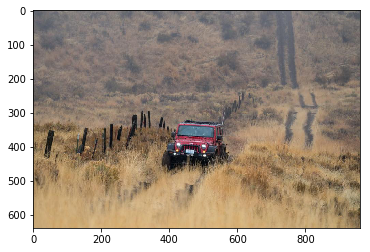

In [3]:
# 首先将图片读入为矩阵
# 我们可以用pyplot的imshow()方法来展示图片
#  这时我曾经拥有的牧马人
#
img_data = imageio.imread('./pics/wranglerJK2.jpg')
#img_data = imageio.imread('./pics/fighters.jpeg')
print(img_data.data.shape)

img = Image.fromarray(img_data, 'RGB')
plt.imshow(img)

In [4]:
def my_init(shape, dtype=None):
    new_mat = np.zeros((shape[0], shape[1], 3, 3))
    for i in range(shape[0]):
        for j in range(shape[1]):
            if j==shape[0]:
                new_mat[:, :, i, j]=0
            else:
                new_mat[:, :, i, j] = filter_mat
    return np.array(new_mat, dtype=dtype)



def MyFilter(image_data):
    img_data = image_data
    print(len(filter_mat.shape))
    if len(filter_mat.shape)!=2:
        print('Invalid filter matrix. It must be 2-D')
        return []
    else:
        kernel_size=filter_mat.shape
        row, col, depth = img_data.shape
        input_shape=img_data.shape
        filter_size = row*col*depth
        print(filter_size)


        model = Sequential()
        model.add(Conv2D(depth, 
                         kernel_size=kernel_size, 
                         input_shape=input_shape, 
                         strides=1,
                         padding='same', 
                         activation='linear', 
                         data_format='channels_last',
                         kernel_initializer=my_init,
                         name='Conv')                         
                  )
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer='sgd', loss='mse')
        model.summary()


        inX = model.input                                          
        outputs = [layer.output for layer in model.layers 
                   if layer.name=='Conv']     
        functions = [K.function([inX], [out]) for out in outputs]   
        layer_outs = [func([img_data.reshape(1, row, col, depth)]) 
                      for func in functions]
        activationLayer = layer_outs[0][0]
        
        temp = (activationLayer-np.min(activationLayer))
        normalized_activationLayer = temp/np.max( np.max(temp))
        
        filter_out = model.layers[0].get_weights()[0]
        return normalized_activationLayer.reshape(row, col, depth), filter_out

[[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]
2
1840320
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv (Conv2D)                (None, 639, 960, 3)       84        
_________________________________________________________________
dense_1 (Dense)              (None, 639, 960, 1)       4         
Total params: 88
Trainable params: 88
Non-trainable params: 0
_________________________________________________________________


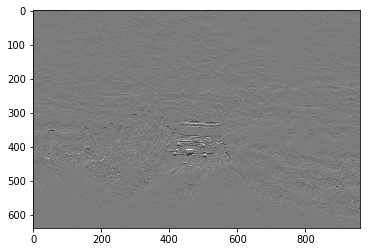

In [5]:
blur_mat = np.array([1, 1, 1, 1, 1, 1, 1,  1, 1]).reshape(3, 3)/9
edge_mat = np.array([-1, -1, -1, -1, 8, -1, -1, -1, -1]).reshape(3, 3)
gaussian_mat = np.array([1, 2, 1, 2, 4, 2, 1, 2, 1]).reshape(3, 3)
sober_mat = np.array([-1, -2, -1, 0, 0, 0, 1, 2, 1]).reshape(3, 3)
sober_matX = sober_mat.T
sharpen_mat = np.array([0, -1, 0, -1, 5, -1, 0, -1, 0]).reshape(3, 3)
filter_mat=sober_mat
print(filter_mat)
outLayer, outFilter = MyFilter(img_data)
#print(outFilter)
plt.imshow(outLayer)

In [6]:
print(outLayer.shape)
#print(img_data)
img2=np.array(outLayer*255, dtype=np.int)
print("====================")
print(img2[:, :, 0])
print("====================")
print(img2[:, :, 2])
#plt.imshow(np.array(outLayer*255, dtype=np.int)[:, :, :])

(639, 960, 3)
[[181 199 196 ... 194 194 176]
 [123 123 123 ... 126 125 125]
 [123 123 123 ... 127 126 125]
 ...
 [124 124 124 ... 128 126 125]
 [124 124 124 ... 127 123 122]
 [ 40  12  12 ...  48  45  62]]
[[181 199 196 ... 194 194 176]
 [123 123 123 ... 126 125 125]
 [123 123 123 ... 127 126 125]
 ...
 [124 124 124 ... 128 126 125]
 [124 124 124 ... 127 123 122]
 [ 40  12  12 ...  48  45  62]]


In [7]:
input_data0 = np.array([1,2,3,4,5,6,7,8,9,10,11,12]) 
input_data = input_data0.reshape(1, 4, 3)
target_data = input_data0.reshape(1,12)
input_shape=input_data.shape

def build_model(input_data, padding_type='same'):
    input_shape = input_data.shape
    model = Sequential()
    model.add(Flatten(input_shape=input_shape[1:]))
    model.compile(optimizer='sgd', loss='mse')
    return(model)

model = build_model(input_data)
print(model.summary())
model.fit(input_data, target_data, batch_size=1)
y = model.predict(input_data)
print(y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 12)                0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1
1/1 [==============================] - 0s 38ms/step - loss: 0.0000e+00
[[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]]


### 使用一维卷积神经网络进行文本分类模型

我们从前面了解到，卷积神经网络具备优异的特征萃取能力，但是通常用在图像数据的建模中，如何用在文本数据中呢？下面我们就来解开谜底。

在实际使用中，一句话都是以单词索引下标表示的列表，长短不一，因此先要对其进行补齐，将每一句话补齐为同样长度，才方便使用。这时可以选择的补齐长度不一，既可以选择最大的句子长度作为需要补齐的长度，也可以选择所有句子长度的中位值来补齐。

把句子补齐之后，每一句话就称为一个整数的时间序列，是一串连续的信号。在使用卷积层的时机上，可以有两种选择。一是直接在这个时候使用，将卷积操作应用于连续的单词下标列表，直接抽取特征；二是先将补齐后的每一句话通过嵌入层映射到一个稍微低维度的致密空间，再对该致密空间的连续信号使用卷积算子，抽取特征。第一种方法因为单词的下标顺序并无特定含义，因此效果不一定好。

在keras中，我们可以使用Embedding层来引入嵌入层，通常直接用在输入层后。我们使用Conv1D来引入一维卷积层。我们甚至可以对信号进行多次卷积。下面分别介绍这两者用法。



Embedding层的作用是将输入的代表文字的单词索引下标转化为固定长度向量，只能用作除开输入层之后的第一层。比如输入的一句话以其单词对应的索引下标表示为一个整数列表：[3， 9， 11， 478， 3， 2]，Embedding层经过计算可能将其转化为[0.45， 1.98， 2.11， 0.04， 0.31]的形式，其中这个向量的大小（5个元素）是作为一个参数输入模型。

下面我们使用上一节使用过的对酒店的褒贬评价作为样例展示实际操作。作为展示，我们这个模型较为简单，结构上是一个嵌入层接上一个一维卷积后再由一个全连接层输出褒贬概率。更为复杂的模型可以在卷积层方面进行复杂化，比如嵌套多个卷积层等。下图展示了一个简单的一维卷积神经网络模型的建模流程：

<img src="./pics/text_CNN_1D.png" width=700>

在数据处理上，我们将把停止词从训练用文本中剔除，主要体现在用于建模的单词下标不包含那些未被纳入的单词集。

In [8]:
def load_hotel_data():
    documents2 = []
    stopword = []
    label = []
    datafile_pos = './nlp_data/hotel_reviews_data/1000_pos.txt'
    datafile_neg = './nlp_data/hotel_reviews_data/1000_neg.txt'
    stopwordfile = './nlp_data/hotel_reviews_data/stopWord.txt'

    # 先读入停止词    
    with open(stopwordfile, encoding='UTF-8') as fo:
        for line in fo:
            stopword.append(line.strip('\n'))

    # 再读入原始评论文档
    with open(datafile_pos, encoding='UTF-8') as fo:
        for line in fo:
            documents2.append(line.strip('\n'))
            label.append(1)

    with open(datafile_neg, encoding='UTF-8') as fo:
        for line in fo:
            documents2.append(line.strip('\n'))    
            label.append(0)
            
    return documents2, label, stopword

documents2, label, stopwords = load_hotel_data();
print(documents2[:3])

['距离川沙公路较近,但是公交指示不对,如果是"蔡陆线"的话,会非常麻烦.建议用别的路线.房间较为简单.', '商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!', '早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。']


In [9]:
stopwords_lst = stopwords; print(stopwords_lst[10:20])
stopwords_str = ' '.join(stopwords); print(stopwords_str[10:50])
stopwords_lst2 = stopwords_str.split(' '); print(stopwords_lst2[10:20])

['：', '；', '？', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎哟']
” 《 》 ！ ， ： ； ？ 人民 末##末 啊 阿 哎 哎呀 哎哟 唉 俺 
['：', '；', '？', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎哟']


我们需要先将停止词从文本中删除。

In [10]:
import jieba
from keras.preprocessing import sequence
import cntext 

In [11]:
max_words = 3000
stopwords_str = ' '.join(stopwords)
tokenizer = cntext.cnTokenizer(num_words=max_words, 
                               filters=stopwords_str, 
                               char_level=False)
tokenizer.fit_on_cntexts(documents2)
text_sequences=tokenizer.cntexts_to_sequences(documents2)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\xieliang\AppData\Local\Temp\jieba.cache
Loading model cost 0.745 seconds.
Prefix dict has been built succesfully.


In [12]:
stopwords_str[:20]

', ? 、 。 “ ” 《 》 ！ ， '

In [13]:
text=documents2[2]
filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
filters2 = filters + stopwords_str
filters2_lst = ' '.join(filters2)
translate_dict = dict((c, ' ') for c in filters)
translate_map = str.maketrans(translate_dict)
text = text.translate(translate_map)
words = jieba.lcut(text.strip())
words_filtered = [w for w in words if w not in filters2_lst]
print(documents2[2])
print(text)
print(words_filtered)

早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。
早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。
['早餐', '太', '无论', '多少', '那边', '不加', '食品', '酒店', '应该', '重视', '一下', '这个', '问题']


In [14]:
index_word_df = pd.DataFrame.from_dict(tokenizer.index_word, 
                                       orient='index')
print('总计单词数：%s' % index_word_df.shape[0])
print('最大建模用索引下标:%s' % 
      np.max([np.max(t) for t in text_sequences]), '\n')
word_counts_df = pd.DataFrame.from_dict(tokenizer.word_counts, 
                                        orient='index', 
                                        columns=['counts'])
word_index_df = pd.DataFrame.from_dict(tokenizer.word_index, 
                                       orient='index', 
                                       columns=['index'])
temp=pd.merge(word_counts_df, word_index_df, 
              left_index=True, right_index=True)
print(temp.sort_values(by='counts', ascending=False).head(10))


总计单词数：8930
最大建模用索引下标:2999 

    counts  index
酒店    1840      1
房间    1398      2
       758      3
住      675      4
服务     646      5
不错     589      6
没有     545      7
入住     499      8
比较     422      9
可以     397     10


In [15]:
documents2[12]

'酒店非常棒，，环境一流，。。'

In [16]:
import numpy as np
temp=' '.join('距离川沙公路较近,但是公交指示不对,如果是"蔡陆线"的话,会非常麻烦.建议用别的路线.房间较为简单.')
#cntext.cntext_to_word_sequence(temp)
#temp2=jieba.cut(temp.strip())
#temp3 = [x for x in temp2 if x!=' ']
np.max([len(x) for x in text_sequences] )
#print(temp3)

226

In [17]:
max_len = 220
text_sequences_padded = sequence.pad_sequences(text_sequences, maxlen=max_len)
x_binary_coding = tokenizer.sequences_to_matrix(text_sequences)
print(x_binary_coding.shape)
print(text_sequences_padded.shape)

(2000, 3000)
(2000, 220)


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = pd.DataFrame(text_sequences_padded)
print(X.head(), X.shape)
Y = pd.get_dummies(label)

ids = [i for i in range(2000)]
model_sample = np.random.choice(ids, 1500, replace=False)
test_sample = [i for i in ids if i not in model_sample]
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.250, random_state = 8798797)
X_train, Y_train = X.iloc[model_sample, :], Y.iloc[model_sample, :]
X_test, Y_test = X.iloc[test_sample, :], Y.iloc[test_sample, :]

#Xb_train, Xb_test, Yb_train, Yb_test = train_test_split(x_binary_coding, Y, test_size=0.25, random_state=138723)
Xb_train, Yb_train = x_binary_coding[model_sample, :], Y.iloc[model_sample, :]
Xb_test, Yb_test = x_binary_coding[test_sample, :], Y.iloc[test_sample, :]

   0    1    2    3    4    5    6    7    8    9    ...   210   211   212  \
0    0    0    0    0    0    0    0    0    0    0  ...    59  2925   201   
1    0    0    0    0    0    0    0    0    0    0  ...    29     2    89   
2    0    0    0    0    0    0    0    0    0    0  ...   569   968  1192   
3    0    0    0    0    0    0    0    0    0    0  ...     0     0     0   
4    0    0    0    0    0    0    0    0    0    0  ...   130   104   206   

    213   214   215  216   217   218   219  
0    12   889   113  507  2267     2  2926  
1  2927  2268   331   11   508   455     6  
2  1329     1   105  890   157    28   146  
3    31  2928   123  320   340  1787    61  
4   456    64  2929  651    44   810   104  

[5 rows x 220 columns] (2000, 220)


In [19]:
print(X_train.shape, X_test.shape)
print(model_sample)

(1500, 220) (500, 220)
[  54  242  807 ...   53 1856  449]


In [20]:
x_binary_coding[test_sample,:].shape

(500, 3000)

In [22]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, SpatialDropout1D, Input
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten, LSTM, Concatenate
from keras.datasets import imdb
from keras.utils import to_categorical
from keras import metrics

In [23]:
sentence_length = X_train.shape[1]
max_features = np.max([np.max(t) for t in text_sequences_padded])
embedding_dims = 1500
filters = 250
kernel_size = 3
hidden_dims = 512
out_dim=2

model = Sequential()

model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=sentence_length))
model.add(SpatialDropout1D(0.5))

model.add(Conv1D(filters, kernel_size, padding='same',
                 activation='relu',strides=1))
model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_dims, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(hidden_dims//2, activation='tanh'))
model.add(Dropout(0.5))

model.add(Dense(out_dim, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 220, 1500)         4498500   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 220, 1500)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 220, 250)          1125250   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               128512    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
0 (InputLayer)                  (None, 220)          0                                            
__________________________________________________________________________________________________
1 (Embedding)                   (None, 220, 1500)    4498500     0[0][0]                          
__________________________________________________________________________________________________
2A (Conv1D)                     (None, 218, 250)     1125250     1[0][0]                          
__________________________________________________________________________________________________
2B (Conv1D)                     (None, 216, 250)     1875250     1[0][0]                          
__________________________________________________________________________________________________
3A (Global

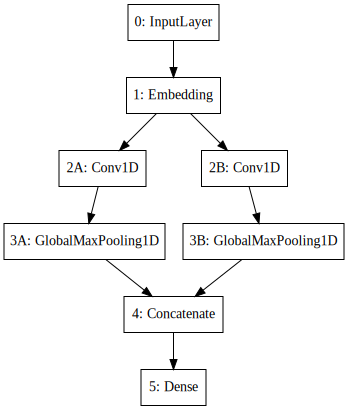

In [24]:
# 同样的模型，用函数式方式表示：

_input = Input(shape=(sentence_length, ), dtype='int32', name='0')
_embedding = Embedding(input_dim=max_features, 
                       output_dim=embedding_dims, 
                       input_length=sentence_length,
                       name='1')(_input)

_conv_0 = Conv1D(filters, kernel_size=3, 
                 activation='relu', name='2A')(_embedding)
_pooling_0 = GlobalMaxPooling1D(name='3A')(_conv_0)

_conv_1 = Conv1D(filters, kernel_size=5, 
                 activation='selu', name='2B')(_embedding)
_pooling_1 = GlobalMaxPooling1D(name='3B')(_conv_1)

_concatenated = Concatenate(axis=1, 
                            name='4')([_pooling_0, _pooling_1])

_output = Dense(2, activation='softmax', name='5')(_concatenated)

model_2 = Model(inputs=_input, outputs=_output)

model_2.summary()

SVG(model_to_dot(model_2).create(prog='dot', format='svg'))

In [23]:
batch_size = 32
epochs = 10
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data = (X_test, Y_test),
          verbose=1)

Train on 1500 samples, validate on 500 samples
Epoch 1/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6815 - acc: 0.5980 - val_loss: 0.4744 - val_acc: 0.8040
Epoch 2/10
1500/1500 [==============================] - 1s 818us/step - loss: 0.3026 - acc: 0.8740 - val_loss: 0.2773 - val_acc: 0.9100
Epoch 3/10
1500/1500 [==============================] - 1s 820us/step - loss: 0.0956 - acc: 0.9687 - val_loss: 0.5871 - val_acc: 0.8340
Epoch 4/10
1500/1500 [==============================] - 1s 819us/step - loss: 0.0337 - acc: 0.9880 - val_loss: 0.4913 - val_acc: 0.8940
Epoch 5/10
1500/1500 [==============================] - 1s 820us/step - loss: 0.0178 - acc: 0.9933 - val_loss: 0.5446 - val_acc: 0.8920
Epoch 6/10
1500/1500 [==============================] - 1s 822us/step - loss: 0.0083 - acc: 0.9993 - val_loss: 0.6125 - val_acc: 0.8920
Epoch 7/10
1500/1500 [==============================] - 1s 818us/step - loss: 0.0044 - acc: 0.9987 - val_loss: 0.5979 - val_acc: 0.8960
Epo

作为比较，我们下面执行两个常见得分类模型：
1. 四层全连接层的深度模型
2. 一个带L2正则项得逻辑斯特回归。L2正则项已经经过挑选。

我们先看这个全连接深度模型。

In [24]:
model0 = Sequential()
model0.add(Dense(1024, input_shape=(Xb_train.shape[1],), activation='tanh'))
model0.add(Dropout(0.5))
model0.add(Dense(512, activation='tanh'))
model0.add(Dropout(0.5))
model0.add(Dense(256, activation='tanh'))
model0.add(Dropout(0.5))
model0.add(Dense(128, activation='tanh'))
model0.add(Dropout(0.5))
model0.add(Dense(2, activation='softmax'))
model0.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              3073024   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
__________

In [25]:
batch_size = 128
epochs = 5
model0.fit(Xb_train, Yb_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(Xb_test, Yb_test),
          verbose=1)

Train on 1500 samples, validate on 500 samples
Epoch 1/5
1500/1500 [==============================] - 1s 719us/step - loss: 0.6415 - acc: 0.6300 - val_loss: 0.3621 - val_acc: 0.8260
Epoch 2/5
1500/1500 [==============================] - 0s 94us/step - loss: 0.3113 - acc: 0.8640 - val_loss: 0.3315 - val_acc: 0.8820
Epoch 3/5
1500/1500 [==============================] - 0s 94us/step - loss: 0.1733 - acc: 0.9353 - val_loss: 0.3722 - val_acc: 0.8800
Epoch 4/5
1500/1500 [==============================] - 0s 96us/step - loss: 0.1081 - acc: 0.9533 - val_loss: 0.4157 - val_acc: 0.8800
Epoch 5/5
1500/1500 [==============================] - 0s 98us/step - loss: 0.0614 - acc: 0.9773 - val_loss: 0.4939 - val_acc: 0.8820


效果非常不错，下面再来看逻辑斯特回归的效果。逻辑斯特回归的输入不能是单词小标的句子组合，而应该是独热编码后的向量。

In [26]:
from sklearn.linear_model import LogisticRegression
y = np.array(label)
clf = LogisticRegression(random_state=0, solver='lbfgs', C=1.05, n_jobs=-1,
                          multi_class='multinomial').fit(Xb_train, Yb_train.iloc[:, 0])

clf.predict_proba(Xb_train[:2, :]) 
print(clf.score(Xb_train, Yb_train.iloc[:, 0]))
print(clf.score(Xb_test, Yb_test.iloc[:, 0]))

0.9906666666666667
0.87


In [27]:
model1 = Sequential()
model1.add(Dense(2, input_shape=(Xb_train.shape[1],), activation='softmax', name='pseudo-logistic'))
model1.add(Dropout(0.25))
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model1.summary()

batch_size = 1
epochs = 5
model1.fit(Xb_train, Yb_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(Xb_test, Yb_test),
          verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pseudo-logistic (Dense)      (None, 2)                 6002      
_________________________________________________________________
dropout_7 (Dropout)          (None, 2)                 0         
Total params: 6,002
Trainable params: 6,002
Non-trainable params: 0
_________________________________________________________________
Train on 1500 samples, validate on 500 samples
Epoch 1/5
1500/1500 [==============================] - 5s 3ms/step - loss: 2.7077 - acc: 0.6090 - val_loss: 0.4487 - val_acc: 0.8540
Epoch 2/5
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3222 - acc: 0.7543 - val_loss: 0.3848 - val_acc: 0.8660
Epoch 3/5
1500/1500 [==============================] - 4s 3ms/step - loss: 2.1418 - acc: 0.8047 - val_loss: 0.3495 - val_acc: 0.8900
Epoch 4/5
1500/1500 [==============================] - 4s 3ms/step - loss: 2.2166 - acc: 0

全连接深度模型和逻辑斯特回归的效果都不错，比用卷积的神经网络模型效果好。这是因为该数据集太小，仅仅有1500个样本供训练，对于卷积神经网络这个稍微复杂的结构来说，还不太够。逻辑斯特回归的鲁棒性在这里表现得比较突出。

### 使用二维卷积神经网络进行文本分类模型

我们也可以使用二维卷积神经网络对文本建模。这是因为，我们可以将一个文本中相邻的单词对应的词向量叠加起来，那么对于任意给定的窗口，这些叠加的词向量就构成一个类似图片的二维“面板”数据。

从《词嵌入与词向量》这节课中我们了解到可以将一组文本中的任意单词映射到一个指定维度的新的空间。这个指定的维度通常比文本中全部单词所需要的维度低很多，但是通常仍然需要数百维。我们需要将使用卷积神经网络将这数百维的向量再次压缩到更低的向量中。对于这样一个一维的连续信号，完全可以使用上面提到的一维卷积方法，一方面可以将维度从数百维降为更低维度，另一方面又能尽可能萃取最有用的信号。

在前面的Conv1D的例子中，我们先通过嵌入层依次读入输入的单词下标后，在一句话读完后，输出一个(样本，句子长度，嵌入层维度)的三维张量，这个张量与一维卷积层需要的维度正好相符，其结构要求为(样本，步数，频道)。一维卷积层在嵌入层这个维度进行卷积操作，生成一个新的(样本，步数，滤子数)的张量供下游网络层使用。

如果要使用二维卷积网络，我们需要将嵌入层输入的数据进行一些维度上的修改，因为Conv2D卷积层接受的输入维度是(样本，行，列，频道数)。这里的行可以对应数据的句子的长度，而列就是嵌入层的维度，我们只需要再告诉程序输入的每一个样本数据是只有一个频道的张量即可：(句子长度，嵌入层维度，1)。这一步可以通过以下代码实现。

使用二维卷积的时候，程序考虑的不仅仅是每一个单词在低维空间映射的维度的卷积，而且也包含了相邻的单词之间的卷积操作，可以挖掘更丰富的信息。

<code>
reshape = Reshape((sequence_length, embedding_dim, 1))(embedding)    
</code>

下图展示了2D卷积神经网络结构的建模流程：

<img src="./pics/text_CNN_2D.png" width=700>

我们仍然以上面的2000条酒店评论数据为例。数据的处理与一维卷积网络模型没有差别，需要注入模型的仍然是一个(样本数，句子长度)的矩阵，每列对应的是在句子该顺序位出现的单词下标。

In [28]:
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model

In [29]:
sentence_length = X_train.shape[1]
max_features = np.max([np.max(t) for t in text_sequences_padded])

embedding_dim = 1024
filter_size = 8
num_filters = 256
hidden_dim=256
out_dim=2
droprate = 0.5

model2 = Sequential()

# 先用一个嵌入层将下标映射到一个致密空间
# 从而每一句话为一个(句长，嵌入维)的矩阵

model2.add(Embedding(max_features,
                     embedding_dim,
                     input_length=sentence_length)
          )
model2.add(Dropout( droprate/2 ))
model2.add(Reshape( (sentence_length, 
                     embedding_dim, 
                     1) )
          )

# we add a Convolution2D
model2.add(Conv2D(num_filters, 
                  kernel_size=(filter_size, filter_size*3), 
                  kernel_initializer='he_uniform',
                  padding='valid', 
                  activation='relu',
                  strides=3))
# 使用全局最大池化约束维度:
model2.add(GlobalMaxPooling2D())

# 标准得全连接层
model2.add(Dense(hidden_dim, activation='tanh'))
model2.add(Dropout( droprate ))
model2.add(Dense(hidden_dim//2, activation='tanh'))
model2.add(Dropout( droprate/2 ))

# 二分类模型得标准做法
model2.add(Dense(out_dim, activation='softmax'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 220, 1024)         3070976   
_________________________________________________________________
dropout_8 (Dropout)          (None, 220, 1024)         0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 220, 1024, 1)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 334, 256)      49408     
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
__________

In [30]:
epochs = 10
batch_size = 1

checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', 
                             monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='auto')

print("Traning Model...")
model2.fit(X_train, Y_train,
           batch_size=batch_size,
           epochs=epochs,
           validation_data = (X_test, Y_test),
           verbose=1)

Traning Model...
Train on 1500 samples, validate on 500 samples
Epoch 1/10
1500/1500 [==============================] - 17s 11ms/step - loss: 0.8684 - acc: 0.4753 - val_loss: 0.6932 - val_acc: 0.5200
Epoch 2/10
1500/1500 [==============================] - 16s 11ms/step - loss: 0.7769 - acc: 0.5020 - val_loss: 0.6992 - val_acc: 0.5000ETA: 3s - loss: 0 - ETA: 2s - loss: - ETA: 1s - loss: 0.7
Epoch 3/10
1500/1500 [==============================] - 16s 11ms/step - loss: 0.6781 - acc: 0.5953 - val_loss: 0.4626 - val_acc: 0.8040
Epoch 4/10
1500/1500 [==============================] - 16s 11ms/step - loss: 0.3547 - acc: 0.8593 - val_loss: 0.4300 - val_acc: 0.8180
Epoch 5/10
1500/1500 [==============================] - 16s 11ms/step - loss: 0.1267 - acc: 0.9627 - val_loss: 0.3790 - val_acc: 0.8800
Epoch 6/10
1500/1500 [==============================] - 16s 11ms/step - loss: 0.0885 - acc: 0.9760 - val_loss: 0.7118 - val_acc: 0.8120
Epoch 7/10
1500/1500 [==============================] - 16s 11m

## 基于RNN/LSTM的文本分类模型

In [31]:
import pandas as pd
import types
import numpy as np
import cntext 
import jieba
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras import metrics

In [32]:
%%time 
file = './nlp_data/douban_moview_reviews/DMSC.csv'
raw = pd.read_csv(file, header=0)
raw.head()

Wall time: 7.17 s


In [33]:
documents = raw.Comment.tolist()
documents2 = documents[:100000]
print(len(documents))

for i in range(4):
    print(documents[i])

2125056
 连奥创都知道整容要去韩国。
 非常失望，剧本完全敷衍了事，主线剧情没突破大家可以理解，可所有的人物都缺乏动机，正邪之间、妇联内部都没什么火花。团结-分裂-团结的三段式虽然老套但其实也可以利用积攒下来的形象魅力搞出意思，但剧本写得非常肤浅、平面。场面上调度混乱呆板，满屏的铁甲审美疲劳。只有笑点算得上差强人意。
 2015年度最失望作品。以为面面俱到，实则画蛇添足；以为主题深刻，实则老调重弹；以为推陈出新，实则俗不可耐；以为场面很high，实则high劲不足。气！上一集的趣味全无，这集的笑点明显刻意到心虚。全片没有任何片段给我有紧张激动的时候，太弱了，跟奥创一样。
 《铁人2》中勾引钢铁侠，《妇联1》中勾引鹰眼，《美队2》中勾引美国队长，在《妇联2》中终于……跟绿巨人表白了，黑寡妇用实际行动告诉了我们什么叫忠贞不二；而且为了治疗不孕不育连作战武器都变成了两支验孕棒(坚决相信快银没有死，后面还得回来)


In [34]:
#读入标准的中文停止词：
stopwords = []
with open('stopwords_std.txt', encoding='UTF-8') as fo:
    for line in fo:
        for w in line.split():
            stopwords.extend(' '.join(line).strip().split())
        
stopwords[:15]

['—', '—', '—', '》', '）', '，', '）', '÷', '（', '１', '－', '”', '，', '）', '、']

In [35]:
num_words = 20000
stopwords_str = ' '.join(stopwords)
stopwords_set = set(stopwords)
tokenizer = cntext.cnTokenizer(num_words=num_words, 
                               filters=stopwords_set, 
                               char_level=False, 
                               min_len=2)
%time tokenizer.fit_on_cntexts(documents)
%time text_sequences=tokenizer.cntexts_to_sequences(documents)
V = len(tokenizer.word_index) + 1

Wall time: 7min 48s
Wall time: 7min 25s


In [36]:
print('总单词量：%s' % len(tokenizer.word_index ))

总单词量：322329


In [37]:
temp = list(text_sequences[:2])
sentence_length = np.max( [len(w) for w in text_sequences])
print('最长句子单词数 ： %s' % sentence_length)
%time text_sequences_padded = sequence.pad_sequences(text_sequences, \
                                                     maxlen=sentence_length)
total_sample = len(text_sequences_padded)

ids = [i for i in range(total_sample)]
model_sample = np.random.choice(ids, 1500000, replace=False)
model_sample_set = set(model_sample)
%time test_sample = [i for i in ids if i not in model_sample_set]

最长句子单词数 ： 70
Wall time: 9 s
Wall time: 403 ms


In [38]:
# 影评打分独热表示
num_classes = raw.Star.max()
target = to_categorical((raw.Star-1).tolist(), num_classes)

Y_train, Y_test = target[model_sample], target[test_sample]
X_train, X_test = text_sequences_padded[model_sample], text_sequences_padded[test_sample]

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, SpatialDropout1D, SpatialDropout2D
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten

In [40]:
# set parameters:
max_features = num_words
batch_size = 64
embedding_dims = 500
filters = 250
kernel_size = 3
hidden_dims = 250
out_dim=Y_train.shape[1]
epochs = 2
print(out_dim)

5


In [41]:
embedding_dim, lstm_dim, hidden_dim = 64, 100, 128
filters, kernel_size = 256, 3
 
# 构建LSTM网络完成评分分析
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, embedding_dim, 
                         input_length = sentence_length
                        ))
model_lstm.add(Conv1D(filters, 
                      kernel_size, 
                      padding='valid',
                      activation='relu',
                      strides=2))
model_lstm.add(LSTM(lstm_dim, 
                    dropout=0.2,
                    recurrent_dropout=0.2))
model_lstm.add(Dense(hidden_dim, activation='tanh'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(hidden_dim//2, activation='tanh'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(out_dim, activation='softmax'))
model_lstm.compile(loss = 'categorical_crossentropy', 
                   optimizer='adam',
                   metrics = ['categorical_accuracy'])
model_lstm.summary()
#=====================================================
embed_dim, lstim_dim = 128, 100
# 构建LSTM网络完成评分分析
model = Sequential()
model.add(Embedding(num_words, embed_dim, 
                    input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_dim, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(hidden_dim, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(hidden_dim//2, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(out_dim, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam',
              metrics = ['categorical_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 70, 64)            1280000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 34, 256)           49408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               142800    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               12928     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
__________

In [42]:
batch_size= 4096
epochs = 20
# 拟合与训练模型
history=model.fit(X_train, Y_train, 
                  batch_size =batch_size, epochs=epochs, verbose=1, 
                  validation_data=(X_test, Y_test)
                 )

Train on 1500000 samples, validate on 625056 samples
Epoch 1/20
1500000/1500000 [==============================] - 136s 91us/step - loss: 1.2112 - categorical_accuracy: 0.4671 - val_loss: 1.1167 - val_categorical_accuracy: 0.5113
Epoch 2/20
1500000/1500000 [==============================] - 135s 90us/step - loss: 1.1221 - categorical_accuracy: 0.5123 - val_loss: 1.0987 - val_categorical_accuracy: 0.5193
Epoch 3/20
1500000/1500000 [==============================] - 136s 90us/step - loss: 1.0998 - categorical_accuracy: 0.5228 - val_loss: 1.0878 - val_categorical_accuracy: 0.5234
Epoch 4/20
1500000/1500000 [==============================] - 136s 91us/step - loss: 1.0855 - categorical_accuracy: 0.5298 - val_loss: 1.0834 - val_categorical_accuracy: 0.5250
Epoch 5/20
1500000/1500000 [==============================] - 135s 90us/step - loss: 1.0737 - categorical_accuracy: 0.5357 - val_loss: 1.0814 - val_categorical_accuracy: 0.5276
Epoch 6/20
1500000/1500000 [==============================] - 

In [43]:
batch_size = 4096
epochs = 10
history_lstm=model_lstm.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, Y_test))

Train on 1500000 samples, validate on 625056 samples
Epoch 1/10
1500000/1500000 [==============================] - 93s 62us/step - loss: 1.2668 - categorical_accuracy: 0.4343 - val_loss: 1.1866 - val_categorical_accuracy: 0.4749
Epoch 2/10
1500000/1500000 [==============================] - 90s 60us/step - loss: 1.1835 - categorical_accuracy: 0.4807 - val_loss: 1.1738 - val_categorical_accuracy: 0.4813
Epoch 3/10
1500000/1500000 [==============================] - 90s 60us/step - loss: 1.1606 - categorical_accuracy: 0.4920 - val_loss: 1.1713 - val_categorical_accuracy: 0.4825
Epoch 4/10
1500000/1500000 [==============================] - 90s 60us/step - loss: 1.1407 - categorical_accuracy: 0.5016 - val_loss: 1.1676 - val_categorical_accuracy: 0.4851
Epoch 5/10
1500000/1500000 [==============================] - 90s 60us/step - loss: 1.1220 - categorical_accuracy: 0.5114 - val_loss: 1.1717 - val_categorical_accuracy: 0.4842
Epoch 6/10
1500000/1500000 [==============================] - 90s 6

### 新闻分类建模，LSTM, LSTM+CNN

In [44]:
import os

读入数据

In [45]:
%%time

text_data_dir = './nlp_data/news_data/'
texts = []  # 用于存储文本的列表
labels_index = {}  # 子目录列表词典，因为每个子目录都是一类对应的文字，所以被称为label
labels = []  # list of label ids
for fname in sorted(os.listdir(text_data_dir)):   #按照文件名依次读入文件夹下所有文本文件
        name = fname.split('_')[0]
        label_id = len(labels_index)
        labels_index[name] = label_id
        fpath = os.path.join(text_data_dir, fname)    # 构造完整文件路径名
        with open(fpath, encoding='UTF-8') as fo:
            for line in fo:
                result = line.split('\u3000\u3000')   # 只保存content列文本
                if len(result)>1:
                    texts.append(result[1])
                    labels.append(label_id)

print('Found %s texts in %s categories' % (len(texts), len(labels_index)))

Found 784909 texts in 10 categories
Wall time: 1.78 s


使用中文标注类处理数据。一开始我们不知道单词表需要保留多少单词用于建模。

In [46]:
stopwords_str = ' '.join(stopwords)
stopwords_set = set(stopwords_str.split())
tokenizer3 = cntext.cnTokenizer( 
                                filters=stopwords_set, 
                                char_level=False, 
                                min_len=2)
%time tokenizer3.fit_on_cntexts(texts)
%time text_sequences=tokenizer3.cntexts_to_sequences(texts)

V = len(tokenizer3.word_index) + 1
print(V)

Wall time: 5min 32s
Wall time: 5min 18s
438529


单词量总计超过40万，我们需要缩减一下建模用的范围。查看出现三次以下的单词个数：

In [47]:
word_counts_df = pd.DataFrame.from_dict(tokenizer3.word_counts, orient='index', columns=['counts'])
word_counts_df.sort_values(by='counts', ascending=False, inplace=True)
lt_3 = np.sum(word_counts_df.counts<=3)
print('总单词数：%s， 低于三次出现的单词数：%s' % (word_counts_df.shape[0], lt_3))

总单词数：438528， 低于三次出现的单词数：272165


我们再看前三万个单词的频次分布：

(50, 5050)

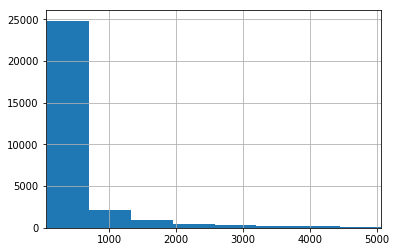

In [48]:
word_counts_df.counts[:30000].hist(bins=200)
plt.xlim(50, 5050)

In [49]:
word_counts_df.counts[80000]

14

In [50]:
num_words = 80000
tokenizer3 = cntext.cnTokenizer( 
                                filters=stopwords_set, 
                                char_level=False, 
                                min_len=2)
%time tokenizer3.fit_on_cntexts(texts)
%time text_sequences=tokenizer3.cntexts_to_sequences(texts)

V = len(tokenizer3.word_index) + 1
print(V)

Wall time: 5min 31s
Wall time: 5min 15s
438529


In [51]:
sentence_length = np.max( [len(w) for w in text_sequences])
print('最长句子单词数 ： %s' % sentence_length)
%time text_sequences_padded = sequence.pad_sequences(text_sequences, \
                                                     maxlen=sentence_length)
total_sample = len(text_sequences_padded)

最长句子单词数 ： 877
Wall time: 5.03 s


In [52]:
ids = [i for i in range(total_sample)]
model_sample = np.random.choice(ids, int(total_sample*0.7), replace=False)
model_sample_set = set(model_sample)
%time test_sample = [i for i in ids if i not in model_sample_set]

num_classes = np.max(labels)+1
target = to_categorical(labels, num_classes)

Y_train, Y_test = target[model_sample], target[test_sample]
X_train, X_test = text_sequences_padded[model_sample], text_sequences_padded[test_sample]

Wall time: 157 ms


现在可以建模了。我们准备了两个模型。一个是标准的LSTM，一个是CNN+LSTM。我们来看看两个模型的效果。

In [55]:
embedding_dim, lstm_dim, hidden_dim = 64, 64, 128
filters, kernel_size = [256, 128], [3, 5]
 
# 构建LSTM网络完成评分分析
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, embedding_dim, 
                         input_length = sentence_length))
model_lstm.add(Conv1D(filters[0], 
                      kernel_size[0], 
                      padding='valid',
                      activation='relu',
                      strides=2))

model_lstm.add(LSTM(lstm_dim, 
                    dropout=0.2, 
                    recurrent_dropout=0.2, return_sequences=True))
model_lstm.add(LSTM(lstm_dim//2, 
                    dropout=0.2, 
                    recurrent_dropout=0.2))

model_lstm.add(Dense(hidden_dim, activation='tanh'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(hidden_dim//2, activation='tanh'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(num_classes, activation='softmax'))
model_lstm.compile(loss = 'categorical_crossentropy', 
                   optimizer='adam',
                   metrics = ['categorical_accuracy'])
model_lstm.summary()
#=====================================================
embed_dim, lstim_dim = 64, 100
# 构建LSTM网络完成评分分析
model = Sequential()
model.add(Embedding(num_words, embed_dim, 
                    input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_dim, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(hidden_dim, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(hidden_dim//2, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam',
              metrics = ['categorical_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 877, 64)           5120000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 438, 256)          49408     
_________________________________________________________________
lstm_6 (LSTM)                (None, 438, 64)           82176     
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_25 (Dense)             (None, 128)               4224      
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
__________

In [56]:
batch_size = 1024
epochs = 1
history=model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, Y_test))

Train on 549436 samples, validate on 235473 samples
Epoch 1/1
549436/549436 [==============================] - 1485s 3ms/step - loss: 1.2477 - categorical_accuracy: 0.5752 - val_loss: 0.9072 - val_categorical_accuracy: 0.6930


In [57]:
batch_size = 512
epochs = 1
history_lstm=model_lstm.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, Y_test))

Train on 549436 samples, validate on 235473 samples
Epoch 1/1
549436/549436 [==============================] - 2259s 4ms/step - loss: 1.1042 - categorical_accuracy: 0.6251 - val_loss: 0.8292 - val_categorical_accuracy: 0.7156
